In [1]:
import numpy as np
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Lambda, Dense
from keras.preprocessing import sequence
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import skipgrams
from IPython.display import Image
import random

import gensim

Using TensorFlow backend.


In [2]:
window_size = 4

In [3]:
def skipgrams(sequence, vocabulary_size,
              window_size=window_size, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                    random.randint(1, vocabulary_size - 1)]
                    for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)
        
    return couples, labels


def generate_data_for_cbow(corpus, window_size, V):
    maxlen = window_size*2
    corpus = tokenizer.texts_to_sequences(corpus)
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [4]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()

corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
V = len(tokenizer.word_index) + 1
V

3388

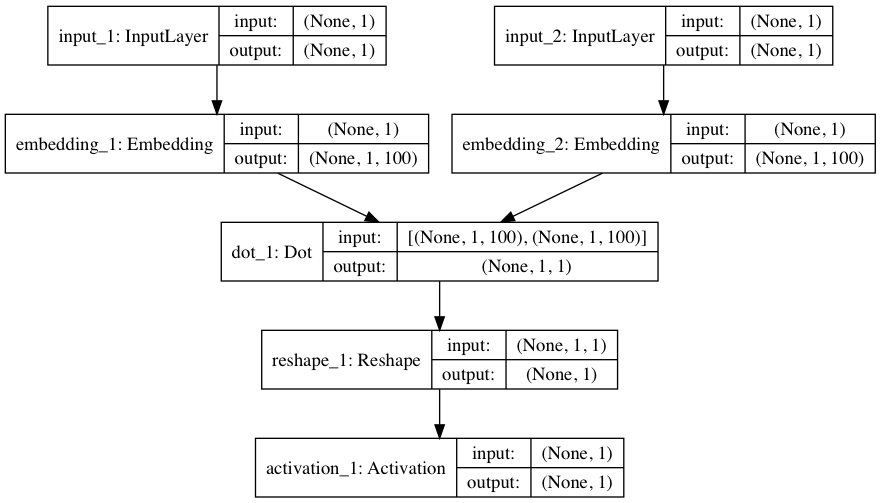

In [5]:
embedding_dim = 100

# inputs
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, embedding_dim)(w_inputs)

# context
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, embedding_dim)(c_inputs)
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

sg_model = Model(inputs=[w_inputs, c_inputs], outputs=o)
# sg_model.summary()
sg_model.compile(loss='binary_crossentropy', optimizer='adam')

Image(model_to_dot(sg_model, show_shapes=True).create(prog='dot', format='png'))

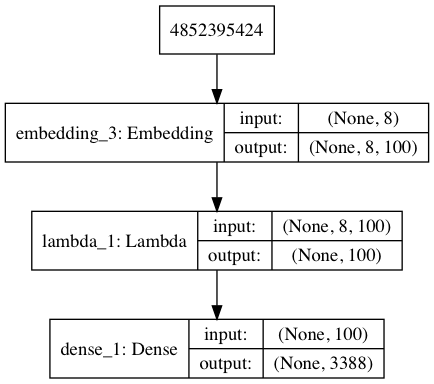

In [6]:
cbow  =  Sequential()
cbow.add(Embedding(input_dim=V, output_dim=embedding_dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
cbow.add(Dense(V, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

Image(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='png'))

In [7]:
for ite in range(5):
    loss = 0.
    for i, doc in enumerate(tokenizer.texts_to_sequences(corpus)):
        data, labels = skipgrams(sequence=doc, vocabulary_size=V, window_size=5, negative_samples=5.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss += sg_model.train_on_batch(x, y)

    print(ite, loss)

0 1098.1835917755961
1 753.1462053358555
2 698.8355008512735
3 669.852522790432
4 645.7601654008031


In [8]:
for ite in range(5):
    loss  =  0.
    for  x, y in generate_data_for_cbow(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)

    print(ite, loss)

0 213960.09788513184
1 205562.4294756353
2 203426.29402136803
3 201760.262461029
4 200879.20343501866


In [9]:
with open('sg_vectors.txt' ,'w') as f:
    f.write('{} {}\n'.format(V-1, embedding_dim))
    vectors = sg_model.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
        
with open('cbow_vectors.txt' ,'w') as f:
    f.write('{} {}\n'.format(V-1, embedding_dim))
    vectors = cbow.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))

In [10]:
sg_model = gensim.models.KeyedVectors.load_word2vec_format('./sg_vectors.txt', binary=False)
cbow_model = gensim.models.KeyedVectors.load_word2vec_format('./cbow_vectors.txt', binary=False)

In [11]:
sg_model.most_similar(positive=['queen'])

[('hearts', 0.7445909976959229),
 ('mock', 0.7306311726570129),
 ('procession', 0.7278381586074829),
 ('the', 0.7277809381484985),
 ('king', 0.7100109457969666),
 ('gryphon', 0.7089172601699829),
 ('verdict', 0.6994239091873169),
 ('verse', 0.6978524923324585),
 ('wildly', 0.6968259811401367),
 ('turtle', 0.6944175958633423)]

In [12]:
cbow_model.most_similar(positive=['queen'])

[('duchess', 0.8688209056854248),
 ('hatter', 0.8669833540916443),
 ('gryphon', 0.8502013683319092),
 ('dormouse', 0.849808394908905),
 ('mock', 0.8221933841705322),
 ('hare', 0.7925328612327576),
 ('turtle', 0.7797635197639465),
 ('cat', 0.7749125957489014),
 ('same', 0.7627409100532532),
 ('march', 0.7458990216255188)]

In [13]:
sg_model.most_similar(positive=['alice'])

[('rather', 0.6344184875488281),
 ('thought', 0.6155545711517334),
 ('poor', 0.6068795919418335),
 ('cautiously', 0.5941371321678162),
 ('‘but', 0.5914756655693054),
 ('perhaps', 0.5902653932571411),
 ('feeling', 0.5816752910614014),
 ('majesty', 0.5746110677719116),
 ('‘i’m', 0.5625320672988892),
 ('hastily', 0.5601295828819275)]

In [14]:
cbow_model.most_similar(positive=['alice'])

[('go', 0.6216853857040405),
 ('the', 0.6183039546012878),
 ('me', 0.6176906824111938),
 ('course', 0.5966371297836304),
 ('it', 0.5909421443939209),
 ('herself', 0.5718881487846375),
 ('yet', 0.5707393288612366),
 ('‘why', 0.5525128841400146),
 ('she', 0.5315719842910767),
 ('indignantly', 0.5293712019920349)]

In [15]:
sg_model.most_similar(positive=['the'])

[('queen', 0.7277809977531433),
 ('professor', 0.6172180771827698),
 ('hare', 0.5903070569038391),
 ('hearts', 0.582216739654541),
 ('laws', 0.5671786069869995),
 ('owner', 0.5587953925132751),
 ('mock', 0.5544295310974121),
 ('u', 0.5483317971229553),
 ('king', 0.5478619337081909),
 ('subject', 0.5475050806999207)]

In [16]:
cbow_model.most_similar(positive=['the'])

[('a', 0.7476465106010437),
 ('and', 0.721807062625885),
 ('this', 0.6751949191093445),
 ('it', 0.6293175220489502),
 ('alice', 0.6183038353919983),
 ('out', 0.6156573295593262),
 ('she', 0.5985218286514282),
 ('her', 0.5934088826179504),
 ('all', 0.5901997685432434),
 ('one', 0.5755230188369751)]

Reference:

* https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py#L143
* https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb